In [133]:
library(Matrix)
library(MGMF)
library(lattice)

## Example data

null device 
          1

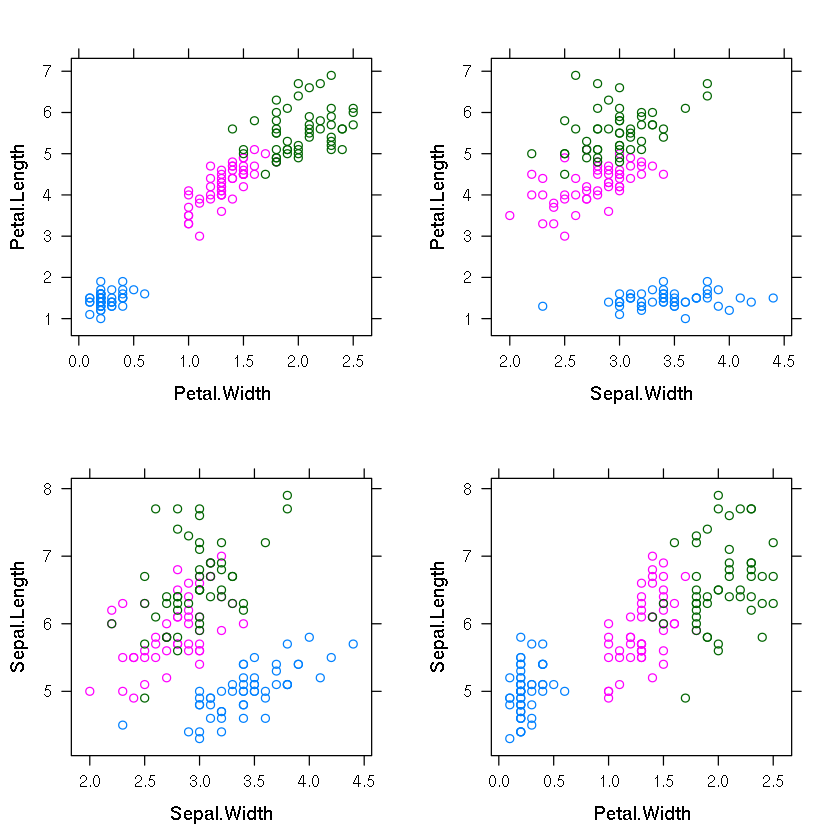

In [2]:
data(iris)
#head(iris)
p1<-xyplot(Sepal.Length~Sepal.Width,data=iris,group=Species)
p2<-xyplot(Petal.Length~Petal.Width,data=iris,group=Species)
p3<-xyplot(Sepal.Length~Petal.Width,data=iris,group=Species)
p4<-xyplot(Petal.Length~Sepal.Width,data=iris,group=Species)
print(p1,c(0,0,0.5,0.5),more=TRUE)
print(p2,c(0,0.5,0.5,1),more=TRUE)
print(p3,c(0.5,0,1,0.5),more=TRUE)
print(p4,c(0.5,0.5,1,1),more=FALSE)
dev.off()

#MGMF Model

Mixture Gaussian Markov Fields uses EM algorithm to maximize the log-likelihood of a following distribution:

$$\prod_n 
\left[  
\sqrt{\frac{\tau_i}{2\pi}}^{s_{j,k}} 
\exp{\left(-\frac{1}{2} s_{j,k} \tau_i \left[ L_n(x,a) \right]^2 \right)} 
\right]
\cdot  \prod_i \Gamma\left(\tau_i,\Omega_{\tau_i}\right) 
\cdot \prod_j \text{Categorical}\left(s_{j,\cdot}, p_l \right)
\cdot \prod_l \text{Dirichlet}\left(p_l,\hat{p}_l\right)
$$
where 
* $s_{j,\cdot}$ is a vector variable distributed by Categorical distribution with probabilities $p_l$ from prior Dirichlet distributions
* $\tau_i$ are precision variables with prior distribution Gamma
* $L_n(x,a)$  are linear functions of data $x$ and latent variables $a$


#Model declaration

In [123]:
#Create a new Mixture Gaussian Markov Fields model
model<-newMGMFmodel()

Declare **data** $x$ as $n$ values of 4 properties.<br>
Organize data variables into 4 columns,
each corresponding to values in 4 dimensions: "Sepal.Length","Sepal.Width","Petal.Length","Petal.Width".
<br>
Each column corresponds to a vector of $n=$NROW(iris) data points.

In [124]:
columns<-c("Sepal.Length","Sepal.Width","Petal.Length","Petal.Width")
df<-data.frame(i=1:NROW(iris))
for (col in columns){
    df[,col]<-model$newData(iris[,col])
}

Declare **latent variables**: cluster means. <br>
In each of 4 columns we define K variables, each corresponding to a cluster mean.

Also declare **precisions** with which data is distributed around means. <br>
For each cluster and each column define a precision with prior distribution $\Gamma\left(1,1/\text{prec}_0\right)$

In [125]:
K<-3
m<-data.frame(k=1:K)
for (col in columns){
    m[,col]<-model$newVariable(n=K)
}
prec<-data.frame(k=1:K)
for (col in columns){
    sdev<-sd(iris[,col])/K
    precision<-1/sdev^2   
    prec[,col]<-model$newPrecision(gamma.prior=matrix(c(1,1/precision),nrow=2,ncol=K))
}

Declare **means prior data** as quantiles of data in each column.

Declare **precisions for prior means** with which means are distributed around mean.priors, one for each column.

In [126]:
m.prior<-data.frame(k=1:K)
for (col in columns){
    m.prior[,col]<-model$newData(quantile(iris[,col],c(1/6,3/6,5/6)))
}
prec.prior<-data.frame(i=1)
for (col in columns){
    sdev<-sd(iris[,col])
    precision<-1/sdev^2   
    prec.prior[,col]<-model$newPrecision(const=precision)
}

Declare **categorical distribution** for the number of cases in each of K clusters, with even Dirichlet prior.

Declare $n$ **indicator variables** coming from the above categorical distribution, each indicating the probability of being in the cluster $k$.

In [127]:
#Indicator variables with prior
p<-model$newCategorical(dirichlet.prior=rep(1,K)/K)
ind<-model$newIndicator(p,n=NROW(iris))
#Now ind+0 are indicators for the first category(cluster), ind+1 for the second category, and so on.

After everything is declared we may now define the MGMF model by declaring **linear functions**: difference between data and cluster means, and link them with corresponding precisions and indicators. <br>

$$ \prod_{\text{col} \in 1..4,\, k\in 1..K,\, i \in 1..N}
\sqrt{\frac{\tau_{k,\text{col}}}{2\pi}}^{s_{i,k}} 
\exp{\left(-\frac{1}{2} s_{i,k} \tau_{k,\text{col}} \left[ x_{i,\text{col}} - m_{k,\text{col}} \right]^2 \right)} 
$$

In [128]:
#Link means with data: data is normally distributed around means
for (col in columns)
    for (k in 1:K){
        #We define NROW(df) linear functions at once, each is a difference between data and mean
        l<-model$newLinElem(variables=c(df[,col],rep(m[k,col],NROW(df))),
                            columns=c(1:NROW(df),1:NROW(df)),
                            coefficients=c(rep(1,NROW(df)),rep(-1,NROW(df))),
                            indicators=ind+(k-1),
                            precisions=prec[k,col])
}

Declare **linear functions** corresponding to difference between mean priors and cluster means. <br>

$$ \prod_{\text{col} \in 1..4,\, k\in 1..K}
\sqrt{\frac{\tau^{\text{prior}}_{\text{col}}}{2\pi}}
\exp{\left(-\frac{1}{2} \tau^{\text{prior}}_{\text{col}} \left[ m_{k,\text{col}} - m^{\text{prior}}_{k,\text{col}} \right]^2 \right)} 
$$

In [129]:
#Link means with mean.priors: means are normally distributed around means.prior
for (col in columns) {   
    #We define K linear functions at once, each is a difference between prior mean and mean    
    l<-model$newLinElem(variables=c(m.prior[,col],m[,col]),
                        columns=c(1:K,1:K),
                        coefficients=c(rep(1,K),rep(-1,K)),
                        indicators=NA, #constant 1 instead of indicators
                        precisions=prec.prior[1,col])
}


#Estimate Maximal Likelihood with EM algorithm

In [130]:
#Run EM algorithm on the model
system.time(
    model$runEM()
)

[1] "EM loop: 10"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
 0.995067077  0.502665835  0.003300462  0.001650231 
[1] "EM loop: 20"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
0.1228529623 0.0400755975 0.0013728709 0.0006864354 
[1] "EM loop: 30"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
0.0491266714 0.0171228694 0.0005259986 0.0002629993 
[1] "EM loop: 40"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
0.0198360867 0.0070913775 0.0002087608 0.0001043804 
[1] "EM loop: 50"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
8.037054e-03 2.902692e-03 8.399682e-05 4.199841e-05 
[1] "EM loop: 60"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
3.260620e-03 1.182495e-03 3.398115e-05 1.699058e-05 
[1] "EM loop: 70"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
1.323498e-03 4.807853e-04 1.377725e-05 6.888627e-06 
[1] "EM loop: 80"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
5.373213e-04 1.953250e-04 5.590764e-06 2.795382e-06 
[1] "EM 

   user  system elapsed 
   2.33    0.00    2.33 

#Analyse clustering results

In [131]:
#Check the clustering performance, assuming assignment when indicator variable is >acc==0.5
acc<-0.5
clust.factor<-factor(1*as.integer(model$getEnv()$indicator[ind+0]>acc)+
                     2*as.integer(model$getEnv()$indicator[ind+1]>acc)+
                     3*as.integer(model$getEnv()$indicator[ind+2]>acc))
#summary(clust.factor)
#summary(interaction(iris$Species,clust.factor))
table(iris$Species,clust.factor)

            clust.factor
              1  2  3
  setosa     50  0  0
  versicolor  0 44  6
  virginica   0  3 47

In [132]:
## Estimated model variables can be accessed using
#model$getEnv()$dataAndVar[df[1,2]]
#model$getEnv()$precision[prec[2,3]]
#model$getEnv()$indicator[ind+1]

null device 
          1

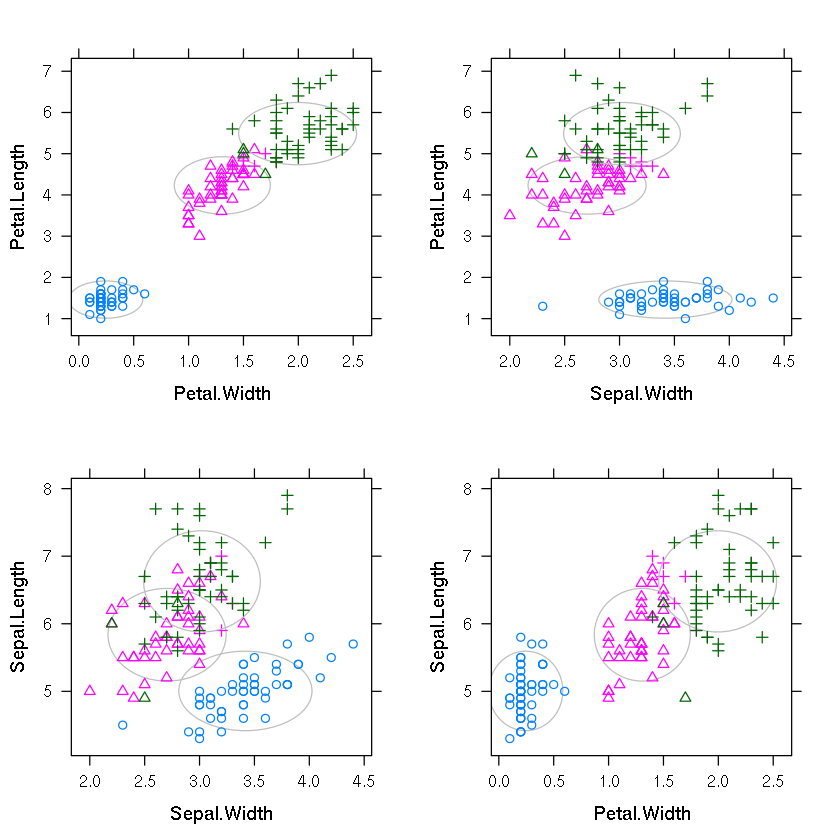

In [118]:
#Clustering performance plot with ellipses indicating fitted Gaussian distributions

give.ellipse<-function(shape,center){
    angles <- seq(0, 2 * pi, length.out = 50 + 1)
    unit.circle <- cbind(cos(angles), sin(angles))
    t(center + 1 * t(unit.circle %*% chol(shape)))
}

iris.xyplot<-function(frm)xyplot(frm,data=iris,group=Species,
        panel=function(...){           
           mypanel.xyplot<-function(x,y,subscripts,type,pch,col,group.number,group.value,
                                    col.line,col.symbol,lty,...){
               #print(group.number)
               col1<-as.character(as.list(frm)[[2]])
               col2<-as.character(as.list(frm)[[3]])
               center<-c(model$getEnv()$dataAndVar[m[group.number,col2]],
                         model$getEnv()$dataAndVar[m[group.number,col1]])
               precision<-c(model$getEnv()$precision[prec[group.number,col2]],
                         model$getEnv()$precision[prec[group.number,col1]])
               sdev<-sqrt(1/precision)
               shape<-matrix(c(sdev[1],0,0,sdev[2]),ncol=2)               
               ell<-give.ellipse(shape,center)
               panel.xyplot(ell[, 1], ell[, 2], type = "l",col="gray")               
               panel.xyplot(x,y,subscripts=subscripts,type=type,
                                pch=clust.factor[subscripts],
                                col.symbol=col.symbol,
                                 ...)
               
          }
          panel.superpose(..., panel.groups=mypanel.xyplot)           
       }                                     
)
p1<-iris.xyplot(Sepal.Length~Sepal.Width)    
p2<-iris.xyplot(Petal.Length~Petal.Width)    
p3<-iris.xyplot(Sepal.Length~Petal.Width)    
p4<-iris.xyplot(Petal.Length~Sepal.Width)        
print(p1,c(0,0,0.5,0.5),more=TRUE)
print(p2,c(0,0.5,0.5,1),more=TRUE)
print(p3,c(0.5,0,1,0.5),more=TRUE)
print(p4,c(0.5,0.5,1,1),more=FALSE)
dev.off()